# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 04/07/2022 | I.S, H.A.  | Anomaly one-hot encoding
1.0     | 30/06/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly
* A comparison of 2 approaches (Naive vs Regex, more complex) was performed, but, with very limited discrepancies between the 2 approaches, we favored the naive one (see : ATTEMPT_1_main_DO_NOT_MODIFY_20220704_Anomaly_ReGex.ipynb).  

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [2]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs
######################
# TIME
from time import time
###################### 
######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
###############################
# Clustering
###############################
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
###############################
# ML preprocessing and models
###############################
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix

import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# LOAD DATA

## Mount GDrive

In [3]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content'

In [4]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [5]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

'Qualified abbreviations_20220707_test.csv'   test_data_final.pkl
'Qualified abbreviations_20220708.csv'	      train_data_final.pkl


## Load data from .pkl file


In [6]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# FEATURE ENGINEERING

## Anomaly

This section 

*   drops the entries with NaN in 'Anomaly'
*   creates and adds to the DataFrame 'df' a one-hot column for each Anomaly root label

Root labels are as defined in the ASRS coding form.pdf

We use a naive approach using string parsing 

### Drop the NaNs in Anomaly

In [7]:
# Drop Anomaly NaN's
print(f"We have {len(df[df['Anomaly'].isna()])} entries where 'Anomaly' == NaN. We drop these entries")

df = df.dropna(axis = 0, how = 'any', subset = ['Anomaly'])
print(f"Current length of our DataFrame: {len(df)}")

We have 431 entries where 'Anomaly' == NaN. We drop these entries
Current length of our DataFrame: 96986


### One-hot encode Anomaly root labels

In [8]:
# Root label (source = ASRS coding forms)
Anomaly_RootLabels=['Aircraft Equipment',
                    'Airspace Violation',
                    'ATC Issue',
                    'Flight Deck / Cabin / Aircraft Event',
                    'Conflict',
                    'Deviation - Altitude',
                    'Deviation - Speed',
                    'Deviation - Track / Heading',
                    'Deviation / Discrepancy - Procedural',
                    'Ground Excursion',
                    'Ground Incursion',
                    'Ground Event / Encounter',
                    'Inflight Event / Encounter',
                    'No Specific Anomaly Occurred']

#### Naive one-hot encoding

In [9]:
# Create a column in the df corresponding to each Anomaly root label 'anomaly_rl'
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_'+anomaly_rl
    
    # Fill the columns in a one-hot-encoding logic
    df[col]=df['Anomaly'].astype('str').apply(lambda x: 1 if (anomaly_rl in x)  else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_'+anomaly_rl
    print('\n',col,'\n',df[col].value_counts())


 Anomaly_Aircraft Equipment 
 0    59054
1    37932
Name: Anomaly_Aircraft Equipment, dtype: int64

 Anomaly_Airspace Violation 
 0    92989
1     3997
Name: Anomaly_Airspace Violation, dtype: int64

 Anomaly_ATC Issue 
 0    81232
1    15754
Name: Anomaly_ATC Issue, dtype: int64

 Anomaly_Flight Deck / Cabin / Aircraft Event 
 0    89839
1     7147
Name: Anomaly_Flight Deck / Cabin / Aircraft Event, dtype: int64

 Anomaly_Conflict 
 0    79622
1    17364
Name: Anomaly_Conflict, dtype: int64

 Anomaly_Deviation - Altitude 
 0    88110
1     8876
Name: Anomaly_Deviation - Altitude, dtype: int64

 Anomaly_Deviation - Speed 
 0    94398
1     2588
Name: Anomaly_Deviation - Speed, dtype: int64

 Anomaly_Deviation - Track / Heading 
 0    88707
1     8279
Name: Anomaly_Deviation - Track / Heading, dtype: int64

 Anomaly_Deviation / Discrepancy - Procedural 
 1    58337
0    38649
Name: Anomaly_Deviation / Discrepancy - Procedural, dtype: int64

 Anomaly_Ground Excursion 
 0    94829
1     

In [11]:
# Plots
# # Parsing de la colonne 'Anomaly' et top 200 des modalités selon le 1/0 encoding
# for anomaly_rl in Anomaly_RootLabels:
#     col='Anomaly_'+anomaly_rl
    
#     title_plot=col +' : ' + str(sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==1]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='green').set(title=title_plot);

#     title_plot='NO '+col +' : ' + str(len(df)-sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==0]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='red').set(title=title_plot);

# NARRATIVE - TEXT PREPROCESSING

## Tokenization Stemming & Stop-word filtering

In [12]:
def tokenize_stem_filter(text):
    """
    Tokenize and stem 'text', then filter out stop-words (incl. user-defined ones)
    Returns the tokenized text as 1st output
    Returns the updated stopwords as 2nd output
    """
    #############################################################
    # TOKENIZATION
    ######################
    from nltk.tokenize import TweetTokenizer 

    tokenizer = TweetTokenizer()
    # "we'll", "didn't", etc. are considered as one word
    tokens = tokenizer.tokenize(text.lower())
    # lower-casing the text is crucial for the stop word filtering below    

    # Alternative: 'normal' tokenizer (yields similar results to TweetTokenizer):
    #from nltk.tokenize import word_tokenize # Tokenization
    #tokens = word_tokenize(text.lower(), language = 'english') 
    
    #############################################################
    # STEMMING
    ######################
    from nltk.stem.snowball import EnglishStemmer

    # inner function
    def stemming(tokens):
        """
        Stem the list of tokens passed as input
        """
        stemmer = EnglishStemmer()
        radicals = []
        
        for word in tokens:
            radical = stemmer.stem(word)
            radicals.append(radical)

        return set(radicals) # remove any duplicates

    # Call the stemming function
    tokens = stemming(tokens)

    #############################################################
    # STOP WORD FILTERING
    ######################
    
    # Import stopwords from nltk.corpus
    from nltk.corpus import stopwords

    # Initialiser la variable des mots vides
    stop_words = set(stopwords.words('english')) 
    # we convert it to a set, more efficient (vs. a liste) 
    # when searching for stopwords. A set also removes duplicates.

    # add additional stop words, if desired : 
    stop_words.update(['.', ';', '[', ']', '(', ')',
                       "they've", "they're", "they'll", 
                       "i've", "i'm", "i'll", "could"])
    
    # inner function
    def stop_words_filtering(my_list):
        """
        Delete stop words from the function input ‘my_list’.
        """
        # remove duplicate words from liste
        set_my_list = set(my_list) 
        my_list = list(set_my_list)

        for stopword in stop_words:

            if stopword in my_list:
                my_list.remove(stopword)

        return my_list

    # call the stop-word filtering function
    tokenized_filtered_words = stop_words_filtering(tokens)
    #############################################################
    
    
    # compile the list of tokens into one text bloc:
    tokenized_filtered_text = ''
    tokenized_filtered_text = ' '.join(entry for entry in tokenized_filtered_words)
    
    return tokenized_filtered_text, stop_words

In [13]:
# Apply the tokenize_stem_filter function to the narratives
# Takes time to execute
data = df['Narrative'][:10000] # pick only 10000 narratives
data = data.map(lambda x: tokenize_stem_filter(x)[0])

In [14]:
data.iloc[0]

"rto offic airspe situat contact time ribbon 110 rev brake gentl compani call note veri kts instrument 85-80 said disagr return yoke tube us use need result cockpit believ tower 30 appli take opinion runway nest mud ani abort 24 hour inform less enter roll posit also held taken revis sit 80 ask cabin chart crew mainten inspect aircraft captain crosscheck felt deactiv taxi came standbi : heavi 8 ground littl appear gate practic becaus whether state procedur dure spoiler relief deceler found sat perform differ lean exit move place assist first cool pitot instruct autobrak exited.th servic pilot cover forward throttl discuss fli takeoff deploy made began ' low park high close speed end wasp indic"

## Vectorization

In [33]:
# # Test the n-gram feature
# text = ['this is a test sentence.']
# vectorizer = CountVectorizer(ngram_range=(1, 2)) # min/max freq. Both can be combined.

# text_vec = vectorizer.fit_transform(text)
# vectorizer.get_feature_names_out()

array(['is', 'is test', 'sentence', 'test', 'test sentence', 'this',
       'this is'], dtype=object)

In [25]:
# initialize and apply the vectorizer 
vectorizer = CountVectorizer(min_df=10, ngram_range=(1, 2))
# vocabulary ignores terms that have a document frequency strictly lower than 'min_df'
# vocabulary ignores terms that have a document frequency strictly higher than 'max_df'.

# ALTERNATIVE:
# select the X most frequent n-grams in the data
#vectorizer = CountVectorizer(max_features = 1000, ngram_range=(1, 2))

data_vec = vectorizer.fit_transform(data)#.todense()

In [26]:
len(vectorizer.get_feature_names_out())

1000

In [27]:
# Visualise the sparse matrix as a pd.DataFrame
# /!\ The following line causes RAM crash, if two many columns (?) !
spm_train = pd.DataFrame(data = data_vec.toarray(), columns = vectorizer.get_feature_names_out())
print(f"Sparse matrix with {spm_train.shape[0]} rows and {spm_train.shape[1]} columns.")

# Sort the vocabulary 
wcnts_train = pd.DataFrame({'spm_train.columns': spm_train.sum(axis = 0)})
wcnts_train = wcnts_train.rename(columns={"spm_train.columns": "occurence"}).sort_values(by = 'occurence', ascending = False)
print("Most frequent words in our vocabulary: \n\n", wcnts_train.head(20), "\n\n")
print("Least frequent words in our vocabulary: \n\n", wcnts_train[-10:])

Sparse matrix with 10000 rows and 1000 columns.
Most frequent words in our vocabulary: 

           occurence
aircraft  6705     
flight    5510     
land      4743     
time      4667     
would     4294     
control   4279     
runway    4220     
approach  4038     
us        3941     
call      3919     
clear     3832     
turn      3646     
back      3645     
pilot     3613     
go        3296     
ask       3233     
fli       3188     
continu   3102     
airport   3022     
first     3006      


Least frequent words in our vocabulary: 

               occurence
abl ask       236      
gate arriv    236      
surpris       235      
serious       235      
realiz made   235      
light 000     235      
member        235      
rain          234      
last said     234      
runway ahead  234      


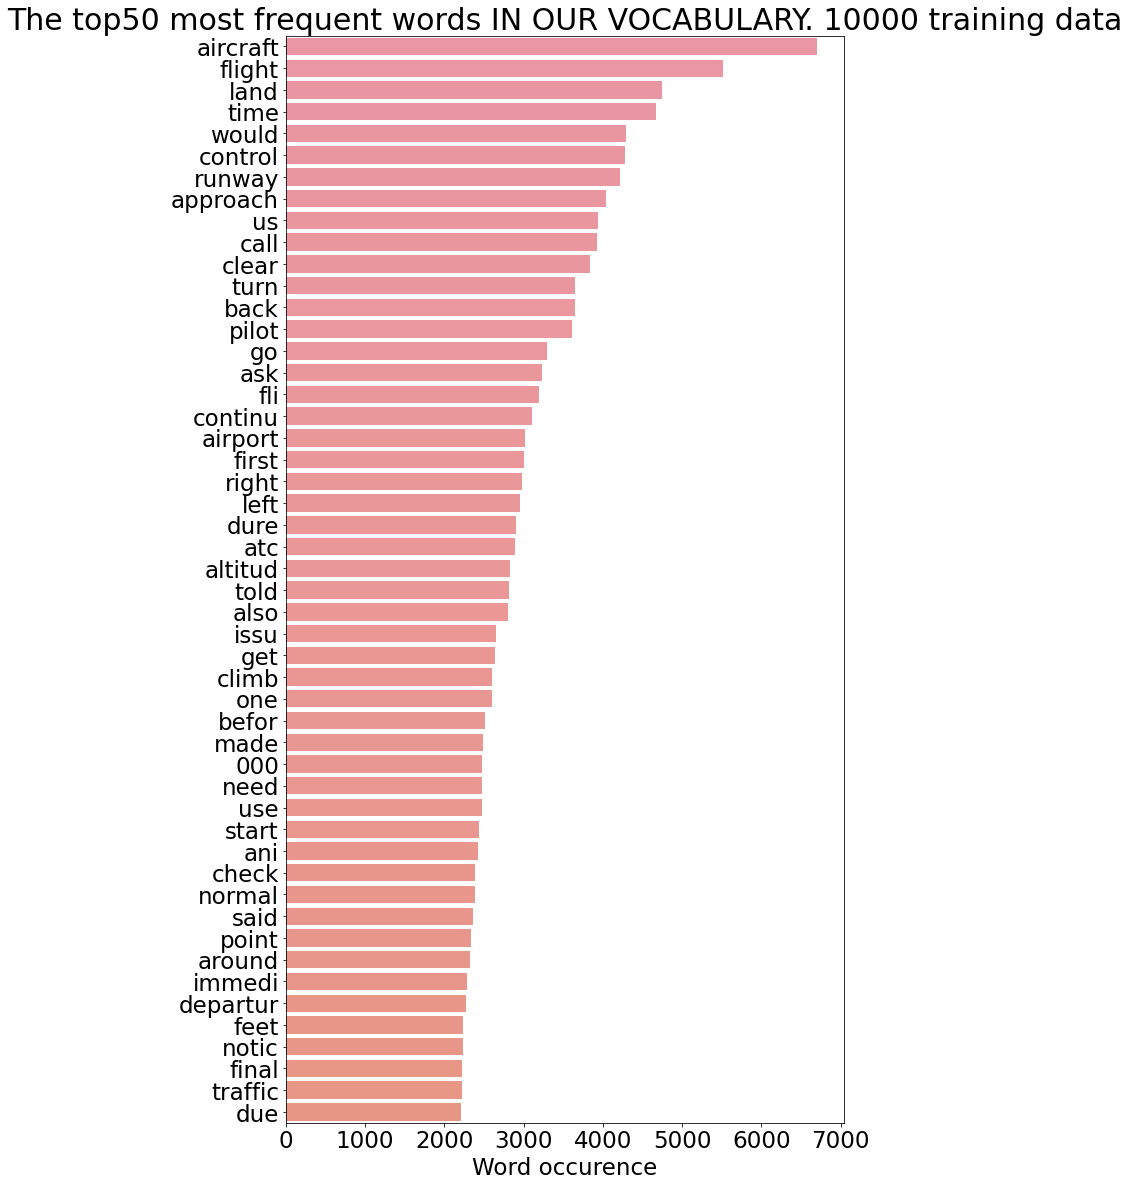

In [28]:
fig = plt.figure(figsize = (10,20)) 
sns.barplot(data = wcnts_train, y = wcnts_train.index, x = 'occurence')
# Plot the x most frequent occurences
topX = 50
plt.ylim(topX - 0.5)
plt.xlabel('Word occurence')
plt.title(f"The top{topX} most frequent words IN OUR VOCABULARY. {data_vec.shape[0]} training data");

In [29]:
def sort_dict(my_dict):
  """
  Return sorted dictionnary
  """
  sorted_dict = {k: v for k, v in sorted(my_dict.items(), reverse = False, key = lambda item: item[1])}
  # A custom key function in form of a lambda function is supplied to customize the sort order:
  # item[1] means we sort by the value of the my_dict.items()
  # item[0] means we sort by the key   of the my_dict.items()

  return sorted_dict

In [30]:
# Return alphabetically-sorted tokens. 
# Each token has is code-number (it’s not its frequency)
sort_dict(vectorizer.vocabulary_)
# for just the vocabulary without the position of the word in the sparse matrix, use ‘get_feature_names_out()’

{'000': 0,
 '10': 1,
 '10 left': 2,
 '100': 3,
 '11': 4,
 '12': 5,
 '13': 6,
 '14': 7,
 '15': 8,
 '16': 9,
 '180': 10,
 '20': 11,
 '200': 12,
 '25': 13,
 '250': 14,
 '30': 15,
 '300': 16,
 '35': 17,
 '40': 18,
 '400': 19,
 '45': 20,
 '50': 21,
 '500': 22,
 '600': 23,
 '700': 24,
 '80': 25,
 '800': 26,
 'abl': 27,
 'abl ask': 28,
 'abnorm': 29,
 'abort': 30,
 'abov': 31,
 'acar': 32,
 'acceler': 33,
 'accept': 34,
 'accomplish': 35,
 'accord': 36,
 'acknowledg': 37,
 'across': 38,
 'action': 39,
 'activ': 40,
 'actual': 41,
 'ad': 42,
 'addit': 43,
 'address': 44,
 'adjust': 45,
 'advis': 46,
 'advis control': 47,
 'advisori': 48,
 'affect': 49,
 'aft': 50,
 'agent': 51,
 'agl': 52,
 'agre': 53,
 'ahead': 54,
 'air': 55,
 'airborn': 56,
 'aircraft': 57,
 'aircraft captain': 58,
 'aircraft descend': 59,
 'aircraft never': 60,
 'aircraft occur': 61,
 'airlin': 62,
 'airplan': 63,
 'airport': 64,
 'airport direct': 65,
 'airspac': 66,
 'airspe': 67,
 'alert': 68,
 'allow': 69,
 'almost': 7

In [24]:
# you can also transform the vocab dictionnary into a list, to be able to slice it
list(sort_dict(vectorizer.vocabulary_))[-1200:-1100]

['us index',
 'us insist',
 'us interphon',
 'us later',
 'us lead',
 'us logbook',
 'us main',
 'us mel',
 'us move',
 'us need',
 'us old',
 'us place',
 'us ra',
 'us radio',
 'us ramp',
 'us rear',
 'us scenario',
 'us shower',
 'us tape',
 'us task',
 'us temp',
 'us thrust',
 'us took',
 'us troubl',
 'us use',
 'us valv',
 'us way',
 'us xxc',
 'usabl',
 'usag',
 'use',
 'use 16',
 'use 500',
 'use affect',
 'use balanc',
 'use begin',
 'use believ',
 'use checklist',
 'use chief',
 'use cockpit',
 'use condit',
 'use copi',
 'use depart',
 'use disappear',
 'use elev',
 'use field',
 'use fluid',
 'use full',
 'use function',
 'use futur',
 'use half',
 'use head',
 'use immin',
 'use initi',
 'use instruct',
 'use know',
 'use languag',
 'use later',
 'use layer',
 'use led',
 'use momentarili',
 'use need',
 'use neither',
 'use okay',
 'use order',
 'use pattern',
 'use pleas',
 'use prepar',
 'use quit',
 'use result',
 'use satcom',
 'use specialist',
 'use suggest',
 'use